<a href="https://colab.research.google.com/github/JapiKredi/RAG_assignment_Research_papers/blob/main/RAG_assignment_Research_papers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Install all the required libraries
!pip install langchain
!pip install pdfplumber
!pip install tiktoken
!pip install openai
!pip install chromaDB
!pip install chromadb
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not insta

In [2]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [ ]:
!pip show langchain

Name: langchain
Version: 0.1.3
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, dataclasses-json, jsonpatch, langchain-community, langchain-core, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [4]:
single_pdf_path = "/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/research_articles/Google_Gemini_paper.pdf"

In [5]:
single_pdf_path

'/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/research_articles/Google_Gemini_paper.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber


In [6]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[0]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Gemini: A Family of Highly Capable
Multimodal Models
GeminiTeam,Google1
Thisreportintroducesanewfamilyofmultimodalmodels,Gemini,thatexhibitremarkablecapabilities
acrossimage,audio,video,andtextunderstanding. TheGeminifamilyconsistsofUltra,Pro,andNano
sizes,suitableforapplicationsrangingfromcomplexreasoningtaskstoon-devicememory-constrained
use-cases. Evaluationonabroadrangeofbenchmarksshowsthatourmost-capableGeminiUltramodel
advancesthestateoftheartin30of32ofthesebenchmarks—notablybeingthefirstmodeltoachieve
human-expertperformanceonthewell-studiedexambenchmarkMMLU,andimprovingthestateofthe
artineveryoneofthe20multimodalbenchmarksweexamined. Webelievethatthenewcapabilitiesof
Geminimodelsincross-modalreasoningandlanguageunderstandingwillenableawidevarietyofuse
casesandwediscussourapproachtowarddeployingthemresponsiblytousers.
1. Introduction
We present Gemini, a family of highly capable multimodal models developed at Google. We trained
Geminijointlyacrossimage,audio,video,andtextdatafor

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [7]:
# Define the path where all pdf documents are present
pdf_path = "/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/research_articles/"

In [8]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [9]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [10]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing ALiBi.pdf
Finished processing ALiBi.pdf
...Processing Flash-attention.pdf
Finished processing Flash-attention.pdf
...Processing Augmenting LLMs Survey.pdf
Finished processing Augmenting LLMs Survey.pdf
...Processing toolformer.pdf
Finished processing toolformer.pdf
...Processing ReACT.pdf
Finished processing ReACT.pdf
...Processing Google_Gemini_paper.pdf
Finished processing Google_Gemini_paper.pdf
...Processing Meta_LlaMA_research.pdf
Finished processing Meta_LlaMA_research.pdf
...Processing attention_all_you_need.pdf
Finished processing attention_all_you_need.pdf
...Processing GPT_4_tech_report.pdf
Finished processing GPT_4_tech_report.pdf
All PDFs have been processed.


In [11]:
# Concatenate all the DFs in the list 'data' together
research_papers_data = pd.concat(data, ignore_index=True)

In [12]:
research_papers_data

,Page No.,Page_Text,Document Name
0,Page 1,PublishedasaconferencepaperatICLR2022 TRAIN SH...,ALiBi.pdf
1,Page 2,"PublishedasaconferencepaperatICLR2022 [[""Extra...",ALiBi.pdf
2,Page 3,"PublishedasaconferencepaperatICLR2022 [[""Train...",ALiBi.pdf
3,Page 4,PublishedasaconferencepaperatICLR2022 Rotary P...,ALiBi.pdf
4,Page 5,PublishedasaconferencepaperatICLR2022 q1 k1 0 ...,ALiBi.pdf
...,...,...,...
341,Page 96,"if err != nil { return nil , err } defer db.Cl...",GPT_4_tech_report.pdf
342,Page 97,"unsanitized user input, which could allow an a...",GPT_4_tech_report.pdf
343,Page 98,Figure 11: Results on IF evaluations across GP...,GPT_4_tech_report.pdf
344,Page 99,Example of Chemical Compound Similarity and Pu...,GPT_4_tech_report.pdf


In [13]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
research_papers_data['Text_Length'] = research_papers_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [14]:
research_papers_data['Text_Length']

0      247
1      247
2      361
3      298
4      287
      ... 
341    188
342    121
343     11
344     96
345     54
Name: Text_Length, Length: 346, dtype: int64

In [15]:
# Retain only the rows with a text length of at least 10
research_papers_data = research_papers_data.loc[research_papers_data['Text_Length'] >= 10]
research_papers_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,PublishedasaconferencepaperatICLR2022 TRAIN SH...,ALiBi.pdf,247
1,Page 2,"PublishedasaconferencepaperatICLR2022 [[""Extra...",ALiBi.pdf,247
2,Page 3,"PublishedasaconferencepaperatICLR2022 [[""Train...",ALiBi.pdf,361
3,Page 4,PublishedasaconferencepaperatICLR2022 Rotary P...,ALiBi.pdf,298
4,Page 5,PublishedasaconferencepaperatICLR2022 q1 k1 0 ...,ALiBi.pdf,287
...,...,...,...,...
341,Page 96,"if err != nil { return nil , err } defer db.Cl...",GPT_4_tech_report.pdf,188
342,Page 97,"unsanitized user input, which could allow an a...",GPT_4_tech_report.pdf,121
343,Page 98,Figure 11: Results on IF evaluations across GP...,GPT_4_tech_report.pdf,11
344,Page 99,Example of Chemical Compound Similarity and Pu...,GPT_4_tech_report.pdf,96


In [18]:
# Store the metadata for each page in a separate column
research_papers_data['Metadata'] = research_papers_data.apply(lambda x: {'Research_Paper': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-18-f6ea2c90f5ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  research_papers_data['Metadata'] = research_papers_data.apply(lambda x: {'Research_Paper': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [19]:
research_papers_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,PublishedasaconferencepaperatICLR2022 TRAIN SH...,ALiBi.pdf,247,"{'Research_Paper': 'ALiBi', 'Page_No.': 'Page 1'}"
1,Page 2,"PublishedasaconferencepaperatICLR2022 [[""Extra...",ALiBi.pdf,247,"{'Research_Paper': 'ALiBi', 'Page_No.': 'Page 2'}"
2,Page 3,"PublishedasaconferencepaperatICLR2022 [[""Train...",ALiBi.pdf,361,"{'Research_Paper': 'ALiBi', 'Page_No.': 'Page 3'}"
3,Page 4,PublishedasaconferencepaperatICLR2022 Rotary P...,ALiBi.pdf,298,"{'Research_Paper': 'ALiBi', 'Page_No.': 'Page 4'}"
4,Page 5,PublishedasaconferencepaperatICLR2022 q1 k1 0 ...,ALiBi.pdf,287,"{'Research_Paper': 'ALiBi', 'Page_No.': 'Page 5'}"
...,...,...,...,...,...
341,Page 96,"if err != nil { return nil , err } defer db.Cl...",GPT_4_tech_report.pdf,188,"{'Research_Paper': 'GPT_4_tech_report', 'Page_..."
342,Page 97,"unsanitized user input, which could allow an a...",GPT_4_tech_report.pdf,121,"{'Research_Paper': 'GPT_4_tech_report', 'Page_..."
343,Page 98,Figure 11: Results on IF evaluations across GP...,GPT_4_tech_report.pdf,11,"{'Research_Paper': 'GPT_4_tech_report', 'Page_..."
344,Page 99,Example of Chemical Compound Similarity and Pu...,GPT_4_tech_report.pdf,96,"{'Research_Paper': 'GPT_4_tech_report', 'Page_..."


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.


## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [16]:
# Set the API key
filepath = "/content/drive/My Drive/GenerativeAI/MateAI/"

with open(filepath + "Jasper_OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [20]:
# Import the OpenAI Embedding Function into chroma
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [22]:
# Define the path where chroma collections will be stored
chroma_data_path = '/content/drive/My Drive/GenerativeAI/MateAI/rag_assignment/ChromaDB_Data'

In [23]:
# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [24]:
# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [25]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
research_paper_collection = client.get_or_create_collection(name='RAG_on_Research_Paper', embedding_function=embedding_function)

In [27]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
documents_list = research_papers_data["Page_Text"].tolist()
metadata_list = research_papers_data['Metadata'].tolist()

In [28]:
metadata_list

[{'Research_Paper': 'ALiBi', 'Page_No.': 'Page 1'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 2'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 3'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 4'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 5'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 6'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 7'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 8'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 9'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 10'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 11'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 12'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 13'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 14'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 15'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 16'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 17'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 18'},
 {'Research_Paper': 'ALiBi', 'Page_No.': 'Page 19'},
 {

In [29]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

research_paper_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-Jmr85***************************************tbik. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [ ]:
# Let's take a look at the first few entries in the collection
research_paper_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
cache_collection = client.get_or_create_collection(name='RAG_on_Research_Paper_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:
# Read the user query
query = input()

In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [ ]:
cache_results

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if key != 'embeddings':
          for i in range(10):
            Keys.append(str(key)+str(i))
            if val is not None:
              if val[0][i] is not None:
                Values.append(str(val[0][i]))

      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


In [ ]:
results_df



```
# This is formatted as code
```

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

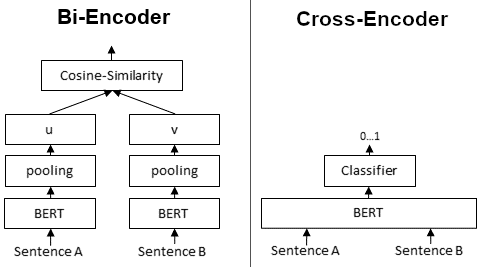

<br>

In [ ]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [ ]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
cross_rerank_scores

In [ ]:
# Store the rerank_scores in results_df
results_df['Reranked_scores'] = cross_rerank_scores

In [ ]:
results_df

In [ ]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

In [ ]:
# Return the top 3 results after reranking
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG

## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
!pip install openai==0.28

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.

                                                """},
              ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response['choices'][0]['message']['content'].split('\n')

In [ ]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [ ]:
# Print the response
print("\n".join(response))

# LangChain multi-doc retriever with ChromaDB

***New Points***
- Multiple Files - PDFs
- ChromaDB - with more meta data?
- Source info
- gpt-3.5-turbo API
- HuggingFace Embeddings
- Instuctor Embeddings
